In [1]:
from STIS_pipeline_functions import *
sns.set_context("talk")

/Users/natalieallen/opt/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


In [2]:
# read in data and calibration files - the test directory I have has 
# two different instruments so I just quickly sort those
data_files = sorted(glob.glob("MAST_2022-03-30T1444/HST/*/*flt.fits"))
files_750 = []
files_430 = []
for i in data_files:
    if "39" in i:
        if "od9m39090" in i:
            flat = i
        else:
            files_750.append(i)
    else:
        files_430.append(i)

In [3]:
# get the data from the files - since I use default settings, it reads out: data, header, jitter, dqs, errors
data = get_data(files_430)

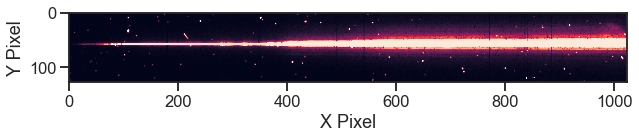

In [85]:
# check on one of the data frames (first part of data)
plt.figure(figsize = (10,10))
im = plt.imshow(data[0][0])
im.set_clim(0,150)
plt.ylabel("Y Pixel")
plt.xlabel("X Pixel")
plt.show()

In [89]:
# initialize a list for and then create traces for each of the data frames
trace_list = []
for i in data[0]:
    # trace wants xi, xf, and an initial y guess - these are numbers I just chose from some testing
    # it can be seen above this just corresponds to the strongest flux
    # this function is fast so you can test for yourself if these values don't work!
    trace = trace_spectrum(i, 550,1000,60)
    trace_list.append(trace)

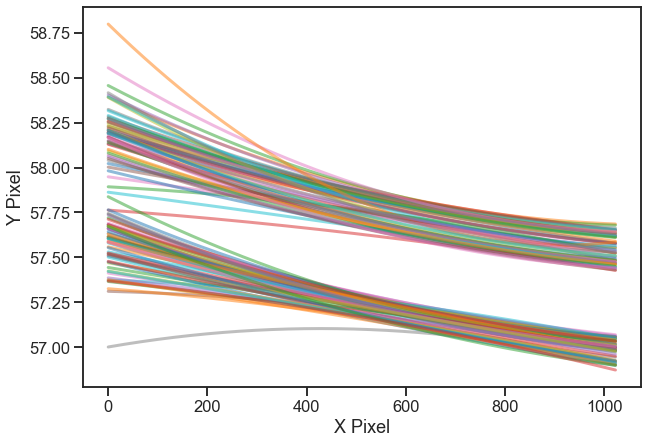

In [90]:
# fit a polynomial to the traces - I just use a second-order chebyshev
# and i fit it over the whole length of the data frame instead of just what was use for the fit
trace_fit = []
plt.figure(figsize = (10,7))
for j in trace_list:
    coeffs1 = chebyshev.chebfit(j[0], j[1], deg=2)
    # plotting just to check everything looks okay
    plt.plot(np.arange(len(data[0][0][0])),chebyshev.chebval(np.arange(len(data[0][0][0])),coeffs1),lw=3, alpha = 0.5)
    trace = [np.arange(len(data[0][0][0])),chebyshev.chebval(np.arange(len(data[0][0][0])),coeffs1)]
    trace_fit.append(trace)
plt.ylabel("Y Pixel")
plt.xlabel("X Pixel")
plt.show()

# there's maybe some outliers here, but this is just an initial trace to feed into the cleaning function
# so we don't worry about it - should subside once the cosmic rays are cleaned

In [7]:
# now to clean the data - default is all steps on (dq, difference_correct, hc_correct, spline_correct)
# i'm breaking up the orbits manually here, not sure what the best way to do this automatically is yet
# the spline function is a little broken at the moment, but if we use optimal extraction it doesn't matter 
# if we don't use it, so we turn it off here
cleaned_1 = clean_data(data[0][:4], dqs = data[3][:4], traces = trace_fit[:4], spline_correct = False)
cleaned_2= clean_data(data[0][4:8], dqs = data[3][4:8], traces = trace_fit[4:8], spline_correct = False)
cleaned_3 = clean_data(data[0][8:12], dqs = data[3][8:12], traces = trace_fit[8:12], spline_correct = False)


In [8]:
cleaned_4 = clean_data(data[0][12:17], data[3][12:17], traces = trace_fit[12:17], spline_correct = False)
cleaned_5 = clean_data(data[0][17:22], data[3][17:22], traces = trace_fit[17:22], spline_correct = False)
cleaned_6 = clean_data(data[0][22:27], data[3][22:27], traces = trace_fit[22:27], spline_correct = False)

cleaned_7 = clean_data(data[0][27:32], data[3][27:32], traces = trace_fit[27:32], spline_correct = False)
cleaned_8 = clean_data(data[0][32:37], data[3][32:37], traces = trace_fit[32:37], spline_correct = False)
cleaned_9 = clean_data(data[0][37:42], data[3][37:42], traces = trace_fit[37:42], spline_correct = False)

cleaned_10 = clean_data(data[0][42:47], data[3][42:47], traces = trace_fit[42:47], spline_correct = False)
cleaned_11 = clean_data(data[0][47:52], data[3][47:52], traces = trace_fit[47:52], spline_correct = False)
cleaned_12 = clean_data(data[0][52:57], data[3][52:57], traces = trace_fit[52:57], spline_correct = False)


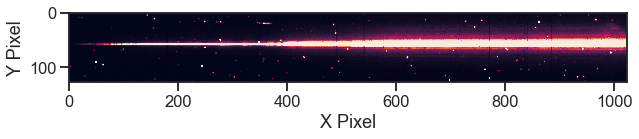

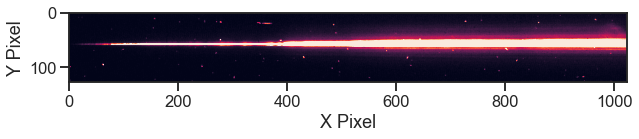

In [87]:
# comparison between the original and the cleaned image
# can easily see the lack of cosmic rays/bad pixels and removal of bad columns
plt.figure(figsize = (10,10))
im = plt.imshow(data[0][1])
im.set_clim(0,200)
plt.ylabel("Y Pixel")
plt.xlabel("X Pixel")
plt.show()
plt.figure(figsize = (10,10))
cim = plt.imshow(cleaned_1[1])
cim.set_clim(0,200)
plt.ylabel("Y Pixel")
plt.xlabel("X Pixel")
plt.show()


In [50]:
# just putting all of the cleaned files into one list
transit_cleaned = [*cleaned_1, *cleaned_2, *cleaned_3, *cleaned_4, *cleaned_5, *cleaned_6, *cleaned_7, *cleaned_8, *cleaned_9, *cleaned_10, *cleaned_11, *cleaned_12]


In [21]:
# save all of the cleaned images - doing this manually now, but will implement into the function later
# probably want to save the file names for the used data files to use
if os.path.exists("cleaned_data") != True:
    os.makedirs("cleaned_data")
for i in range(len(transit_cleaned)):
    filename = "cleaned_time_" + str(i).zfill(3) + ".fits"
    fits.writeto("cleaned_data/"+filename, transit_cleaned[i], data[1][i])#, overwrite=True)
    fits.append("cleaned_data/"+filename, data[4][i])


In [4]:
# and then just write the jitter dictionary to a pickle file for later use
with open('jitter.pkl', 'wb') as handle:
    pickle.dump(data[2], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# now that we have the cleaned files, we don't need to run any of the above code a second time
# read those files in to have this as a new starting point
cleaned_data = sorted(glob.glob("cleaned_data/cleaned*"))
transit_cleaned = []
headers = []
errs = []
for i in cleaned_data:
    c_data, hdr = fits.getdata(i, ext = 0, header = True)
    transit_cleaned.append(c_data)
    headers.append(hdr)
    e_data = fits.getdata(i, ext = 1)
    errs.append(e_data)

with open('jitter.pkl', 'rb') as handle:
    jit = pickle.load(handle)

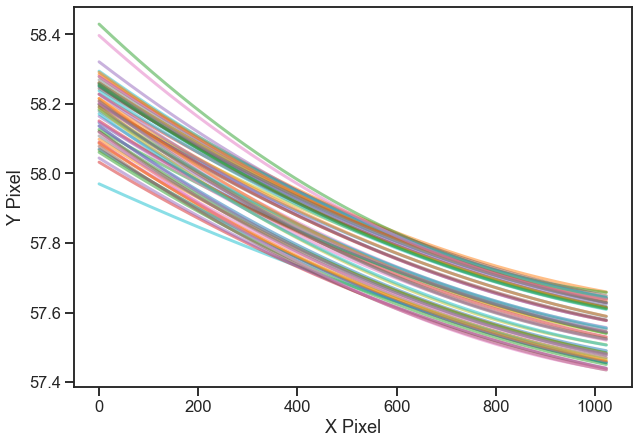

In [3]:
# now to retrace the cleaned data
trace_list = []
plt.figure(figsize = (10,7))
for i in transit_cleaned:
    trace = trace_spectrum(i, 550,1000,60)
    trace_list.append(trace)

trace_fit = []
for j in trace_list:
    coeffs1 = chebyshev.chebfit(j[0], j[1], deg=2)
    plt.plot(np.arange(len(transit_cleaned[0][0])),chebyshev.chebval(np.arange(len(transit_cleaned[0][0])),coeffs1),lw=3, alpha = 0.5)
    trace = [np.arange(len(transit_cleaned[0][0])),chebyshev.chebval(np.arange(len(transit_cleaned[0][0])),coeffs1)]
    trace_fit.append(trace)
plt.ylabel("Y Pixel")
plt.xlabel("X Pixel")
plt.show()
# looks good! can see they all match now because this is just one transit, unlike the previous one which was two different visits

In [4]:
# now for the spectral extraction - I use optimal since I don't do the spline cleaning
spectra = []
for i in range(len(transit_cleaned)):
    spec = spectral_extraction(transit_cleaned[i], trace_fit[i], method = "optimal")
    spectra.append(spec)

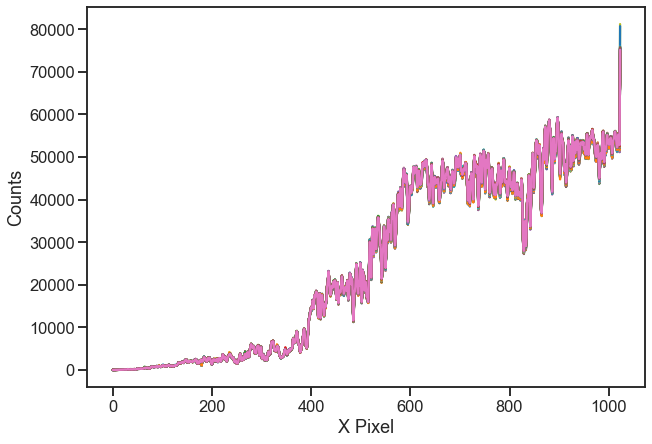

In [5]:
# plot all of the spectra on top of each other - looks pretty typical
plt.figure(figsize = (10,7))
for i in spectra:
    plt.plot(i[1])
plt.ylabel("Counts")
plt.xlabel("X Pixel")
plt.show()

In [6]:
# sum up each of the spectra for the white light curve
lc = []
lc_err = []
for i in spectra:
    point = np.nansum(i[1])
    # i assume error prop is just like sqrt(sum of squares of errors)
    # optimal extraction outputs inverse variance, so assume np.sqrt(np.nansum((1/np.sqrt(i[2]))**2)) is the error on each point
    err = np.sqrt(np.nansum((1/np.sqrt(i[2]))**2))
    lc.append(point)
    lc_err.append(err)

In [7]:
# now to deal with the timestamps. HST header times come in JDUTC, we want BJD-TBD 
times = times_to_bjd(headers, starname = "WASP-69")
times_start = times[0][0]
times_end = times[0][1]

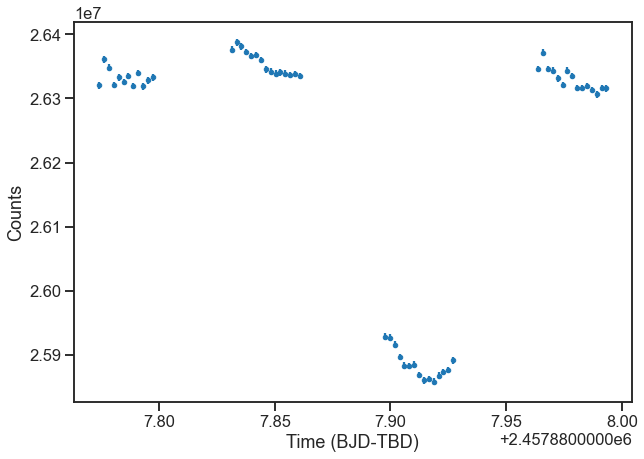

In [8]:
# should now be able to plot our raw white light curve - looks pretty good!
plt.figure(figsize = (10,7))
plt.errorbar(times[0][0], lc, yerr = lc_err, fmt = ".")
plt.xlabel("Time (BJD-TBD)")
plt.ylabel("Counts")
plt.show()

In [9]:
# before fitting, we just need to normalize our jitter vectors into standard deviation
jit_use = ["V2_roll", "V3_roll", "Latitude", "Longitude", "RA", "DEC"]
norm_jit = {}
for i in jit_use:
    norm = (jit[i][:57]/np.nanmean(jit[i][:57]))-1
    norm_jit[i] = norm/np.std(norm)

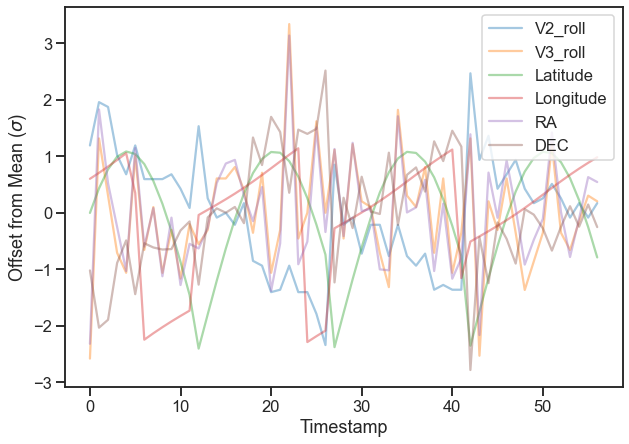

In [10]:
# check them out 
plt.figure(figsize = (10,7))
for i in norm_jit:
    plt.plot(norm_jit[i], alpha = 0.4, label = str(i))
plt.xlabel("Timestamp")
plt.ylabel(r"Offset from Mean ($\sigma$)")
plt.legend()
plt.show()

In [11]:
# now for our white light curve + systematics fit
# first, a jitter systematics detrending fit
jitter_fit = white_light_fit(times_start, lc, norm_jit, sys_method = "jitter")
# this outputs a data cube [fit_param, fit_uncs, model_final, lc]

In [13]:
# then, a gp systematics detrending fit
# if you use the gp method, you need to provide a name for an output folder with gp_name
gp_fit = white_light_fit(times_start, lc, norm_jit, sys_method = "gp", gp_name = "wasp-69_full_test")
# this outputs a juliet "results" type - will show some ways of how to use that below

  analysing data from wasp-69_full_test/jomnest_.txt


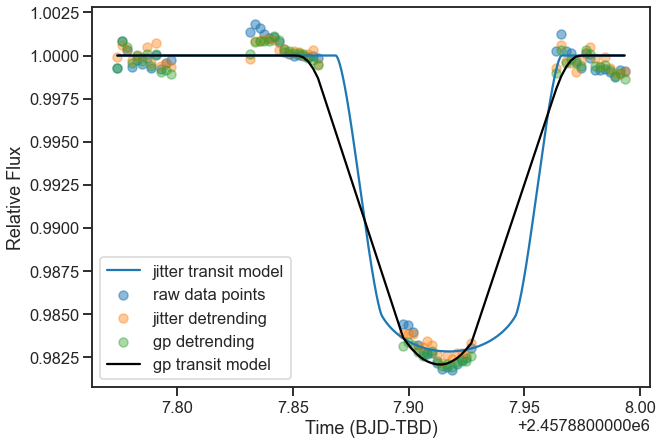

In [14]:
# let's plot the results of these fits 
plt.figure(figsize = (10,7))
# first the jitter detrending
t_final = np.linspace(times_start[0], times_start[-1], 1000)
plt.plot(t_final, jitter_fit[2][1], label = "jitter transit model")
plt.scatter(times_start, (lc/jitter_fit[2][0]), label = "raw data points", alpha = 0.5)
plt.scatter(times_start, (lc/jitter_fit[2][0])/jitter_fit[2][2], alpha=0.4, label = "jitter detrending")

# then the gp detrending
transit_plus_GP_model = gp_fit.lc.evaluate('stis1')#, t = t, GPregressors = t)
transit_model = gp_fit.lc.model['stis1']['deterministic']
gp_model = gp_fit.lc.model['stis1']['GP']
# there may be a small vertical offset between the two models because of the different normalizations - account for that
offset = jitter_fit[2][1][0] - transit_model[0]
plt.scatter(times_start, (lc/lc[0]) - (transit_plus_GP_model - transit_model) + offset,alpha=0.4, label = "gp detrending")
plt.plot(times_start, transit_model + offset, color='black',zorder=10, label = "gp transit model")

# obviously the transit models are very different at the moment - i'm mostly just comparing the actual detrending of the
# data points so ignore that for now

plt.legend()
plt.ylabel("Relative Flux")
plt.xlabel("Time (BJD-TBD)")
plt.show()

In [15]:
# seems clear that the first (non one second) point in each orbit is causing problems - let's manually remove it
# and try the fits again. the first in each orbit will be the 0, 12, 27, 42 points
lc_less = np.copy(lc)
lc_less = np.delete(lc_less, [0,12,27,42])
times_less = np.copy(times[0][0])
times_less = np.delete(times_less, [0,12,27,42])

In [16]:
norm_jit_less = {}
for i in norm_jit.keys():
    less = np.delete(norm_jit[i], [0,12,27,42])
    norm_jit_less[i] = less

In [17]:
# retry the jitter and gp fits without the first point in each orbit
jitter_fit_less = white_light_fit(times_less, lc_less, norm_jit_less, sys_method = "jitter")
gp_fit_less = white_light_fit(times_less, lc_less, norm_jit_less, sys_method = "gp", gp_name = "wasp-69_less")

  analysing data from wasp-69_less/jomnest_.txt


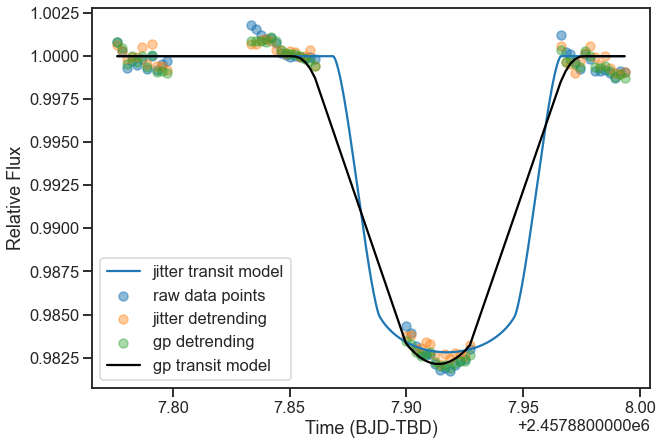

In [20]:
# plot the new result
plt.figure(figsize = (10,7))
# first the jitter detrending
t_final_less = np.linspace(times_less[0], times_less[-1], 1000)
plt.plot(t_final_less, jitter_fit_less[2][1], label = "jitter transit model")
plt.scatter(times_less, (lc_less/jitter_fit_less[2][0]), label = "raw data points", alpha = 0.5)
plt.scatter(times_less, (lc_less/jitter_fit_less[2][0])/jitter_fit_less[2][2], alpha=0.4, label = "jitter detrending")

# then the gp detrending
transit_plus_GP_model_less = gp_fit_less.lc.evaluate('stis1')#, t = t, GPregressors = t)
transit_model_less = gp_fit_less.lc.model['stis1']['deterministic']
gp_model_less = gp_fit_less.lc.model['stis1']['GP']
offset_less = jitter_fit_less[2][1][0] - transit_model_less[0]
plt.scatter(times_less, (lc_less/lc_less[0]) - (transit_plus_GP_model_less - transit_model_less) + offset_less ,alpha=0.4, label = "gp detrending")
plt.plot(times_less, transit_model_less + offset_less, color='black',zorder=10, label = "gp transit model")

plt.legend()
plt.ylabel("Relative Flux")
plt.xlabel("Time (BJD-TBD)")
plt.show()